In [1]:
import cv2
import glob
import os
import datetime
import numpy as np
import os.path as osp
from pathlib import Path

import torch
from dpvo.dpvo import DPVO
from dpvo.utils import Timer
from dpvo.config import cfg

import torch
import numpy as np
import torch.nn.functional as F

from dpvo.extractor import * 

import torch.quantization.quantize_fx as quantize_fx
import copy

from pprint import pprint
from dpvo.q_extractor import *


from dpvo.net import *

In [2]:
config = "../config/default.yaml"
# DPVO.load_weights(cfg.merge_from_file(config) ,"../dpvo.pth")

slam = DPVO(cfg, "../dpvo.pth", ht=480, wd=640, viz=False)


In [12]:
extractor = slam.network.patchify.fnet

In [4]:
import functools
def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

In [505]:

def quantize_uniform(data, n_bits, clip, device='cuda'): 
    clip = .5
    w_c = data.clamp(-clip, clip)
    b = torch.pow(torch.tensor(2.0), 1 - n_bits).to(device)
    w_q = clip * torch.min(b * torch.round(w_c / (b * clip)), 1 - b) 
    return w_q


class QConv2d(nn.Conv2d):
    def __init__(self, quant_scheme, quant_args=None, init_args=None, b=None, *kargs, **kwargs):
        super(QConv2d, self).__init__(*kargs, **kwargs) 
        self.weight = init_args
        self.bias = b
        self.quant_args = quant_args

        for k, v in kwargs.items():
            setattr(self, k, v)

    def forward(self, inputs):
        self.quantize_params()
        return F.conv2d(inputs, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

    def quantize_params(self):
        unquantized_weights = rgetattr(self,'weight')
        # self.bias = rgetattr(self,'bias')
        quantized_weights = torch.nn.Parameter(quantize_uniform(unquantized_weights,self.quant_args,1,'cpu')) 
        # print(quantized_weights)
        rsetattr(self, 'weight', quantized_weights)
        return


In [5]:
copy_model = copy.deepcopy(extractor)

layers = dict(copy_model.named_modules())

In [507]:
copy_model.conv2.weight.shape

torch.Size([128, 64, 1, 1])

In [575]:
conv_layers = []
for item in layers:
    if "conv" in item:
        conv_layers.append(item)
        W = layers[item].weight
        
        kwargs = {
            "in_channels": W.shape[0],
            "out_channels": W.shape[1],
            "kernel_size": W.shape[2],
            "stride": layers[item].stride[0],
            "padding": layers[item].padding[0],
            "dilation": layers[item].dilation[0],
            "groups": layers[item].groups,
        }

        b = layers[item].bias
        new_layer = QConv2d('uniform', 6, W, b, **kwargs)        
        setattr(copy_model, item, new_layer)

In [574]:
w8 = w_quantize.copy()

In [576]:
for item in conv_layers:
    getattr(copy_model, item).quantize_params()

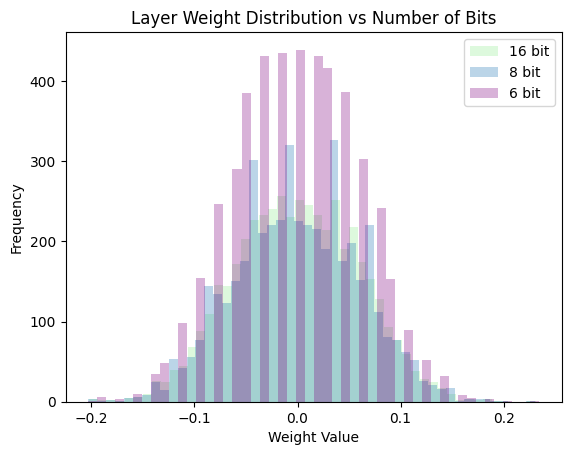

In [580]:
weights = extractor.conv1.weight.view(-1)
weights = weights.cpu().detach().numpy()

w_quantize = copy_model.conv1.weight.view(-1)
w_quantize = w_quantize.cpu().detach().numpy()


# # plot weighst as a histogram
import matplotlib.pyplot as plt
# plt.hist(weights, bins=50, alpha=0.3, label="float32")
plt.hist(w16, bins=50, color='lightgreen', alpha=0.3, label="16 bit")
plt.hist(w8, bins=50, alpha=0.3, label="8 bit")
plt.hist(w_quantize, bins=50, color="purple", alpha=0.3, label="6 bit")


plt.title("Layer Weight Distribution vs Number of Bits")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()



In [374]:
# import torch.quantization.quantize_fx as quantize_fx
# import copy

# copy_model.eval()

# qconfig_dict = {"": torch.quantization.default_dynamic_qconfig}
# model_prepared = quantize_fx.prepare_fx(copy_model, qconfig_dict)
# copy_model = quantize_fx.convert_fx(model_prepared)

In [6]:
x = torch.rand(1,3,3,224,224, dtype=torch.float32).cuda()
copyx = copy_model(x)
regx = extractor(x)



In [528]:
copyx.view(-1)[0:5]

tensor([-0.6746,  0.2009,  1.1632,  0.8417,  0.3978], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [529]:
regx.view(-1)[0:5]

tensor([-0.6633,  0.2104,  1.1705,  0.8555,  0.3979], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [306]:
model = copy_model
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.692MB


In [8]:
q_extractor = QuantizedEncoder()
q_extractor.copy_params(extractor)

In [9]:
q_extractor.quantize_params()

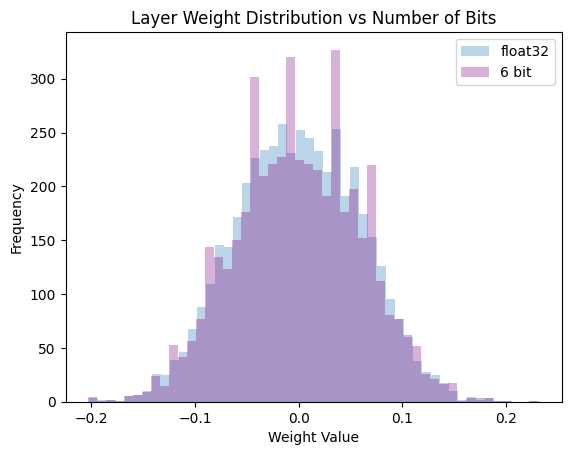

In [14]:
weights = extractor.conv1.weight.view(-1)
weights = weights.cpu().detach().numpy()

# w_quantize = q_extractor.encoder.conv1.weight.view(-1)
# w_quantize = w_quantize.cpu().detach().numpy()

w_quantize = qvo.patchify.fnet.encoder.conv1.weight.view(-1)
w_quantize = w_quantize.cpu().detach().numpy()


# # plot weighst as a histogram
import matplotlib.pyplot as plt
plt.hist(weights, bins=50, alpha=0.3, label="float32")

plt.hist(w_quantize, bins=50, color="purple", alpha=0.3, label="6 bit")


plt.title("Layer Weight Distribution vs Number of Bits")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()



In [3]:
trained_fnet = slam.network.patchify.fnet
trained_inet = slam.network.patchify.inet

In [9]:
qpatch = QuantizedPatchifier(num_bits=8)
qpatch.copy_and_quantize(trained_fnet, trained_inet)

In [10]:
qpatch.fnet.encoder.conv1.weight.view(-1)[0:5]

tensor([-0.0547, -0.0508, -0.0039, -0.0469, -0.0586], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [4]:
qvo = copy.deepcopy(slam.network)

In [6]:
qvo.swap_patchifier(8, trained_fnet, trained_inet)

In [10]:
qvo.patchify.fnet.encoder.conv1.weight.view(-1)[0:5] - qpatch.fnet.encoder.conv1.weight.view(-1)

dpvo.net.QuantizedPatchifier